In [ ]:
!pip install transformers datasets torch

!pip install transformers[torch] accelerate -U

import accelerate
import transformers

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch

  Using cached accelerate-0.31.0-py3-none-any.whl (309 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [ ]:
# Charger le dataset
df = pd.read_csv('/content/concatenated_df2.csv')

# Prétraitement : Assurez-vous que votre dataset a les colonnes 'review_body' et 'review_body_sentiment_label'
df = df[['review_body', 'review_body_sentiment_label']]

In [ ]:
# Nettoyer les données
df = df.dropna(subset=['review_body'])  # Supprimer les lignes avec des valeurs manquantes
df['review_body'] = df['review_body'].astype(str)  # S'assurer que toutes les valeurs sont des chaînes de caractères

<ipython-input-3-fae273537c24>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_body'] = df['review_body'].astype(str)  # S'assurer que toutes les valeurs sont des chaînes de caractères


In [ ]:
# Renommer la colonne 'review_body_sentiment_label' en 'labels' pour correspondre aux attentes du modèle
df.rename(columns={'review_body_sentiment_label': 'labels'}, inplace=True)

In [ ]:
# Séparer en ensembles d'entraînement et de test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Convertir en Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenizer les données
def tokenize_function(examples):
    return tokenizer(examples['review_body'], padding='max_length', truncation=True)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/204336 [00:00<?, ? examples/s]

Map:   0%|          | 0/51085 [00:00<?, ? examples/s]

In [ ]:
# Définir le modèle
num_labels = len(df['labels'].unique())
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits) # Convert logits to PyTorch tensor if it's a NumPy array
    labels = torch.tensor(labels) # Convert labels to PyTorch tensor if it's a NumPy array
    predictions = torch.argmax(logits, dim=-1)
    accuracy = (predictions == labels).sum().item() / len(labels)
    return {"accuracy": accuracy}

In [ ]:
!pip install transformers[torch] accelerate -U


In [ ]:


# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Créer l'objet Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [ ]:
# Entraîner le modèle
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.198200,0.247475,0.933033
2,0.167400,0.218105,0.942664
3,0.117600,0.223833,0.945385


TrainOutput(global_step=38313, training_loss=0.1724595271582406, metrics={'train_runtime': 27533.7485, 'train_samples_per_second': 22.264, 'train_steps_per_second': 1.391, 'total_flos': 1.6129062997460582e+17, 'train_loss': 0.1724595271582406, 'epoch': 3.0})

In [ ]:
# Évaluer le modèle
results = trainer.evaluate()
print(f"Accuracy: {results['eval_accuracy']:.2f}")

Accuracy: 0.95


In [ ]:
import shutil
# Sauvegarder le modèle et le tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

# Compresser le répertoire sauvegardé pour le téléchargement
shutil.make_archive('saved_model', 'zip', './saved_model')

'/content/saved_model.zip'

In [ ]:
# Évaluer le modèle sur le dataset de test
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']:.2f}")

Test Accuracy: 0.95


In [ ]:
from sklearn.metrics import f1_score, classification_report
# Évaluer le modèle sur le dataset de test
test_predictions = trainer.predict(test_dataset)
test_logits = test_predictions.predictions
test_labels = test_predictions.label_ids
test_predictions = torch.argmax(torch.tensor(test_logits), dim=-1)

# Évaluer le modèle sur le dataset d'entraînement
train_predictions = trainer.predict(train_dataset)
train_logits = train_predictions.predictions
train_labels = train_predictions.label_ids
train_predictions = torch.argmax(torch.tensor(train_logits), dim=-1)
# Calculer les métriques pour le dataset de test
test_f1 = f1_score(test_labels, test_predictions, average='weighted')
test_report = classification_report(test_labels, test_predictions, output_dict=True)
test_f1_per_class = {f"f1_class_{k}": v["f1-score"] for k, v in test_report.items() if k.isdigit()}

# Calculer les métriques pour le dataset d'entraînement
train_f1 = f1_score(train_labels, train_predictions, average='weighted')
train_report = classification_report(train_labels, train_predictions, output_dict=True)
train_f1_per_class = {f"f1_class_{k}": v["f1-score"] for k, v in train_report.items() if k.isdigit()}

# Afficher les résultats pour le dataset de test
print(f"Test F1 Score: {test_f1:.2f}")
for key, value in test_f1_per_class.items():
    print(f"{key}: {value:.2f}")

# Afficher les résultats pour le dataset d'entraînement
print(f"Train F1 Score: {train_f1:.2f}")
for key, value in train_f1_per_class.items():
    print(f"{key}: {value:.2f}")

Test F1 Score: 0.95
f1_class_0: 0.95
f1_class_1: 0.90
f1_class_2: 0.96
Train F1 Score: 0.98
f1_class_0: 0.98
f1_class_1: 0.95
f1_class_2: 0.99


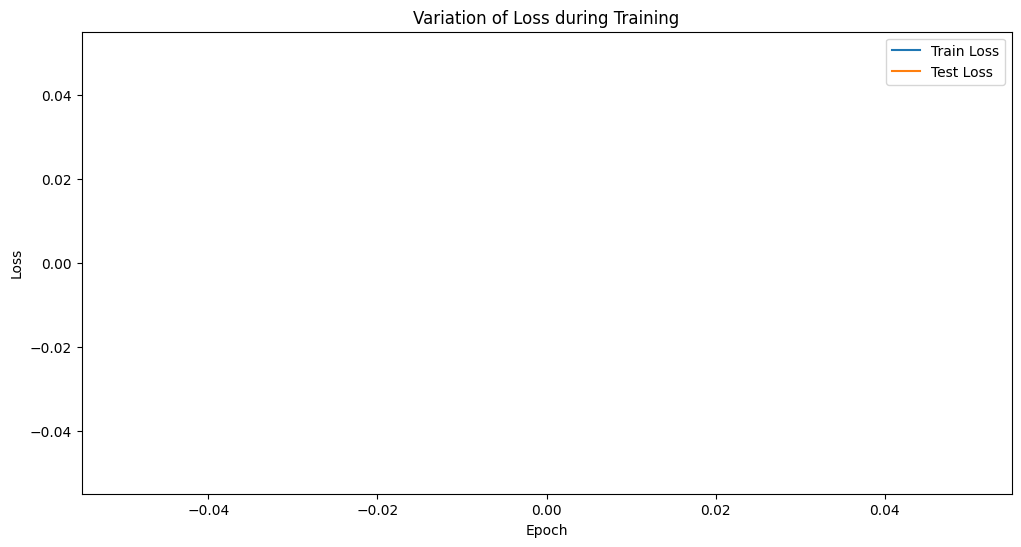

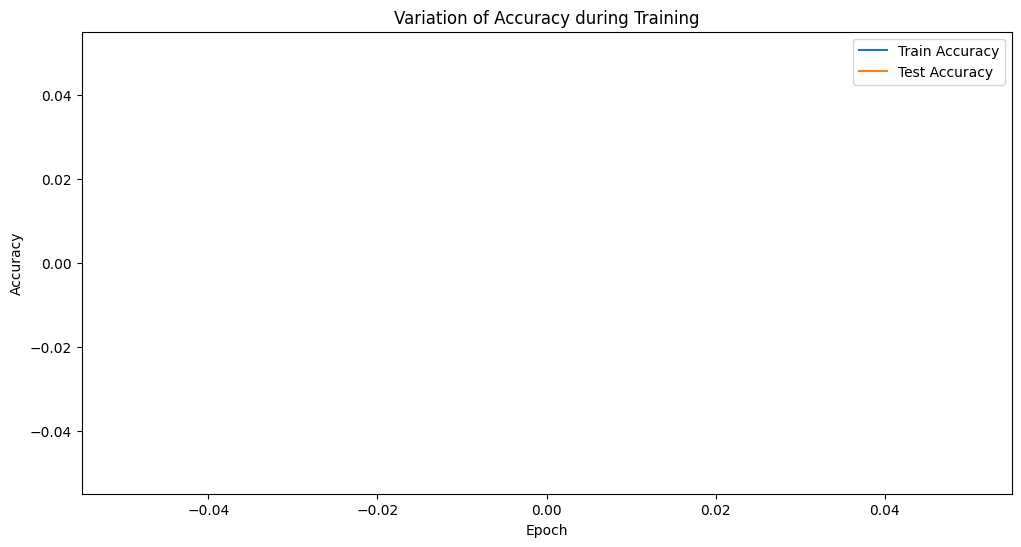

In [ ]:
import json
import os
import matplotlib.pyplot as plt

# Fonction pour lire les logs de l'entraînement
def read_logs(output_dir):
    log_files = [f for f in os.listdir(output_dir) if f.startswith('trainer_state')]
    logs = []
    for log_file in log_files:
        with open(os.path.join(output_dir, log_file), 'r') as f:
            logs.extend(json.load(f)['log_history'])
    return logs

# Lire les logs
output_dir = './results'  # Remplacez par le chemin vers votre répertoire de sortie
logs = read_logs(output_dir)

# Extraire les métriques
train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
train_accuracy = [log['accuracy'] for log in logs if 'accuracy' in log]
eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]

# Tracer la variation de la loss pendant l'entraînement
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Variation of Loss during Training')
plt.show()

# Tracer la variation de l'accuracy pendant l'entraînement
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(eval_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Variation of Accuracy during Training')
plt.show()
